# Problem Definition

The current project is a Text Classification problem, specifically Sentiment Analysis. The dataset we will be using is the Large Movie Review Dataset, which can be found at http://ai.stanford.edu/~amaas/data/sentiment/. We will try to solve the sentiment analysis problem to classify movie reviews as either positive or negative. This will be a supervised text classification problem because both the training data and test data movie reviews contain labels for either positive sentiment or negative sentiment. 

# Data Cleaning

In [5]:
#pip install wordcloud

In [6]:
import glob
import os
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt

In [7]:
def get_data(split):
    if split.lower() == "train":
        folder = "train"
    elif split.lower() == "test":
        folder = "test"
    else:
        raise ValueError("Invalid data split specified.")

    file_names = []
    text = []
    is_positive = []

    # read all positive files
    files = glob.glob(os.path.join("data", folder, "pos", "*"))
    for file in files:
        head, tail = os.path.split(file)
        file_names.append(tail)
        is_positive.append(1)
        with open(file, "rb") as open_file:
            text.append(open_file.readlines()[0])

    # read all negative files
    files = glob.glob(os.path.join("data", folder, "neg", "*"))
    for file in files:
        head, tail = os.path.split(file)
        file_names.append(tail)
        is_positive.append(0)
        with open(file, "rb") as open_file:
            text.append(open_file.readlines()[0])

    return pd.DataFrame(
        data={"file": file_names, "text": text, "is_positive": is_positive}
    )


train_df = get_data("train")
train_df["text"] = train_df["text"].astype(str)
train_df

,file,text,is_positive
0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1
1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1
2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1
3,10002_7.txt,b'This is easily the most underrated film inn ...,1
4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1
...,...,...,...
24995,9998_4.txt,"b""Towards the end of the movie, I felt it was ...",0
24996,9999_3.txt,b'This is the kind of movie that my enemies co...,0
24997,999_3.txt,"b""I saw 'Descent' last night at the Stockholm ...",0
24998,99_1.txt,"b""Some films that you pick up for a pound turn...",0


### Get only 5000 records from the original 25000 highly polar movie reviews

In [8]:
positive_reviews = train_df[:2500]  # take first 2500 reviews which are positive
negative_reviews = train_df[22500:]  # last last 2500 reviews which are negative
new_train = positive_reviews.append(negative_reviews, ignore_index=True)

In [9]:
new_train

,file,text,is_positive
0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1
1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1
2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1
3,10002_7.txt,b'This is easily the most underrated film inn ...,1
4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1
...,...,...,...
4995,9998_4.txt,"b""Towards the end of the movie, I felt it was ...",0
4996,9999_3.txt,b'This is the kind of movie that my enemies co...,0
4997,999_3.txt,"b""I saw 'Descent' last night at the Stockholm ...",0
4998,99_1.txt,"b""Some films that you pick up for a pound turn...",0


### Basic Properties of the Dataset

In [10]:
# list column names and datatypes
new_train.dtypes

file           object
text           object
is_positive     int64
dtype: object

In [11]:
# length of dataframe
len(new_train)

5000

######  Tokenization is the process of breaking down chunks of text into smaller pieces.  Word tokenization separates text into individual words.
###### We will then filter out stop words to remove common English words such as "the", "and", "him" which will not be needed for modelling.

In [12]:
from nltk.corpus import movie_reviews  #  this is the corpus we will use
from nltk.stem.snowball import SnowballStemmer  #  Snowball stemmer > Porter stemmer
from nltk.tokenize.casual import (
    casual_tokenize,
)  # we use casual tokenize because this is colloquial text
from sklearn.feature_extraction.text import (
    ENGLISH_STOP_WORDS as sklearn_stop_words,
)  # sklearn stop words is larger than nltk

import re

stemmer = SnowballStemmer("english")
nltk.download("wordnet")
from nltk.stem import WordNetLemmatizer

from collections import defaultdict
lemmatizer = WordNetLemmatizer()


def decontracted(phrase):
    # Taken from https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


def tokenize_phrase(text):
    phrase = decontracted(
        text.replace("\\", "").replace("b'", "")
    )  # remove backslashes and replace contractions
    tokens = casual_tokenize(phrase, reduce_len=True, strip_handles=True)
    normalized_tokens = [x.lower() for x in tokens]  #  convert to all lowercase
    filtered_tokens = [
        x for x in normalized_tokens if x not in sklearn_stop_words
    ]  #  filter stop words
    filtered_tokens = [
        x
        for x in filtered_tokens
        if x and x not in "- \t\n.\"':[...][\\]()/[br]<>*~,;!?"
    ]  #  filter punctuations
    lemmatized_tokes = [
        lemmatizer.lemmatize(t) for t in tokens
    ]  # perform lemmatization
    stemmed_tokens = [stemmer.stem(w) for w in filtered_tokens]  # perform stemming
    pos_tokens = nltk.pos_tag(stemmed_tokens)  # perform part-of-speech tagging
    return pos_tokens


new_train["tokens"] = new_train["text"].apply(tokenize_phrase)
new_train

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qt09n\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,file,text,is_positive,tokens
0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1,"[(bromwel, RB), (high, JJ), (cartoon, NN), (co..."
1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1,"[(homeless, NN), (houseless, NN), (georg, NN),..."
2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1,"[(brilliant, JJ), (over-act, JJ), (lesley, NN)..."
3,10002_7.txt,b'This is easily the most underrated film inn ...,1,"[(easili, NN), (underr, JJ), (film, NN), (inn,..."
4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1,"[(typic, NN), (mel, NN), (brook, NN), (film, N..."
...,...,...,...,...
4995,9998_4.txt,"b""Towards the end of the movie, I felt it was ...",0,"[(end, NN), (movi, NN), (felt, VBD), (technic,..."
4996,9999_3.txt,b'This is the kind of movie that my enemies co...,0,"[(kind, NN), (movi, NN), (enemi, NN), (content..."
4997,999_3.txt,"b""I saw 'Descent' last night at the Stockholm ...",0,"[(saw, JJ), (descent, NN), (night, NN), (stock..."
4998,99_1.txt,"b""Some films that you pick up for a pound turn...",0,"[(film, NN), (pick, NN), (pound, NN), (turn, V..."


Convert tokens to their own DataFrame so we can perform descriptive statistics on them.

In [13]:
import itertools

new_train["tokens_with_positive"] = new_train.apply(
    lambda x: [token + (x["is_positive"],) for token in x["tokens"]], axis=1
)
token_df = pd.DataFrame(
    list(itertools.chain.from_iterable(new_train["tokens_with_positive"])),
    columns=["token", "part_of_speech", "is_positive"],
)
token_df

,token,part_of_speech,is_positive
0,bromwel,RB,1
1,high,JJ,1
2,cartoon,NN,1
3,comedi,NN,1
4,ran,VBD,1
...,...,...,...
538085,time,NN,0
538086,money,NN,0
538087,wast,NN,0
538088,time,NN,0


# Data Exploration

Some descriptive statistics about the tokens

In [14]:
token_df[["token", "is_positive"]].groupby("token").count().rename(
    columns={"is_positive": "count"}
).sort_values(by=["count"], ascending=False)

,count
token,
movi,10057
film,9632
like,4492
just,3621
time,3217
...,...
one--h,1
one-and-a-half,1
one-and-a-half-hour,1


In [15]:
token_df[["part_of_speech", "is_positive"]].groupby("part_of_speech").count().rename(
    columns={"is_positive": "count"}
).sort_values(by=["count"], ascending=False)

,count
part_of_speech,
NN,301175
JJ,116896
VBP,27889
VBD,14881
RB,13626
VB,12327
NNS,10388
IN,10151
CD,8738


Normalization of words is condensing different forms of the same word into a single word. For example, "watched", "watching" and "watches" will be normalized to "watch".

Two main ways for normalization is through stemmming and lemmatization. In stemming, the common word endings such as "-ing", "s", "-ed", "-de" are removed from the smallest unit of the word. There may be some issues with words which have special conjugations, for example "feel" and "felt", since stemming just removes common word endings from the string. The relationship betwen "feel" and "felt" may not be recognized, and the stemming process may result in words which are not actual words.

Lemmatization uses a data structure to relate different forms of a word to its dictionary form or root word (lemma). Lemmatization will return an actual word in a language.

Modified from https://realpython.com/sentiment-analysis-python/


Descriptive statistics of tokens and part-of-speech tagging, indicating there are 29,531 unique words and 38 unique pos in our sample reviews, and the most frequent word is "movie" and pos is "NN".

In [16]:
# describe categorical columns of token_df - unique, top and frequency of token and part-of-speech
token_df.describe(include=np.object).transpose()

,count,unique,top,freq
token,538090,29531,movi,10057
part_of_speech,538090,38,NN,301175


Look at the number of words for positive and negative reviews. It shows positive reviews generally have (275637-262453)/2500=5.27 more words than negative ones per review.

In [17]:
# group by positivity, count distinct pos and number of words
posneg_df = (
    token_df.groupby("is_positive")
    .agg({"part_of_speech": pd.Series.nunique, "token": pd.Series.count})
    .rename(columns={"pos": "pos_unique", "token": "token_count"})
    .sort_values("token_count", ascending=False)
)

# show top 5 records
posneg_df.head(5)

,part_of_speech,token_count
is_positive,,
1,36,275637
0,38,262453


Look at the positive review rates, as well as the number of words, by each pos. It's shown that reviews contain NN (common nouns) the most, followed by JJ (adjectives). 59.4% PRP and 58.4% RBS are from positive reviews, which are the highest among all pos, indicating when reviewers use more PRP (personal pronouns) and RBS (adverb superlative), they tend to give positive reviews, say, than using WP (Wh-pronouns such as what, which, who, whoever).

In [18]:
# group by part-of-speech, count positivity rates and number of words by POS
pos_df = (
    token_df.groupby("part_of_speech")
    .agg({"is_positive": pd.Series.mean, "token": pd.Series.count})
    .rename(columns={"is_positive": "pos_rate", "token": "token_count"})
    .sort_values("token_count", ascending=False)
)

# show top 10 records
pos_df.head

<bound method NDFrame.head of                 pos_rate  token_count
part_of_speech                       
NN              0.518300       301175
JJ              0.511284       116896
VBP             0.503998        27889
VBD             0.495800        14881
RB              0.481433        13626
VB              0.492253        12327
NNS             0.496534        10388
IN              0.482317        10151
CD              0.505951         8738
VBN             0.511503         6346
VBZ             0.541467         3123
JJS             0.524126         2860
JJR             0.498231         1696
FW              0.536700         1485
RBR             0.446858         1289
NNP             0.514238         1194
CC              0.465909         1144
VBG             0.567568          851
MD              0.550162          309
RBS             0.584229          279
$               0.392996          257
RP              0.468599          207
``              0.463768          207
WP              0.37

Look at the frequency of each token.

In [19]:
# group by token, count frequency of each token
numtoken_df = (
    token_df.groupby("token")
    .agg({"token": pd.Series.count})
    .rename(columns={"token": "token_count"})
    .sort_values("token_count", ascending=False)
)

# show top 10 records
numtoken_df.head(10)

,token_count
token,
movi,10057
film,9632
like,4492
just,3621
time,3217
good,2989
make,2935
watch,2875
charact,2819


Five number summary for the number of tokens dataframe. The token counts by part of speech range from just 1  to 10057 counts for "movie".

In [20]:
numtoken_df.describe()

,token_count
count,29531.000000
mean,18.221191
std,124.115929
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,10057.000000


## Data Visualization

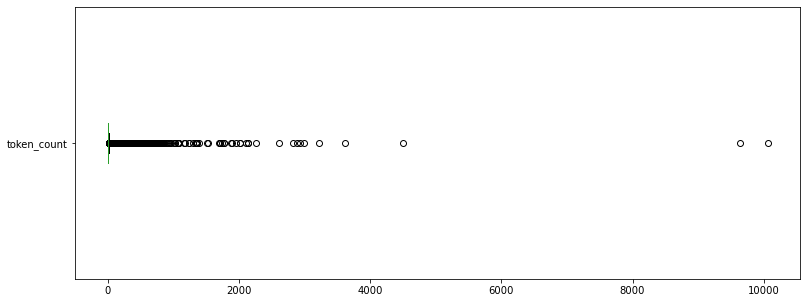

In [21]:
# horizontal boxplot of a dataframe column - frequency of tokens
numtoken_df[["token_count"]].plot(kind="box", vert=False, figsize=(13, 5));

Frequency distribution of each token.

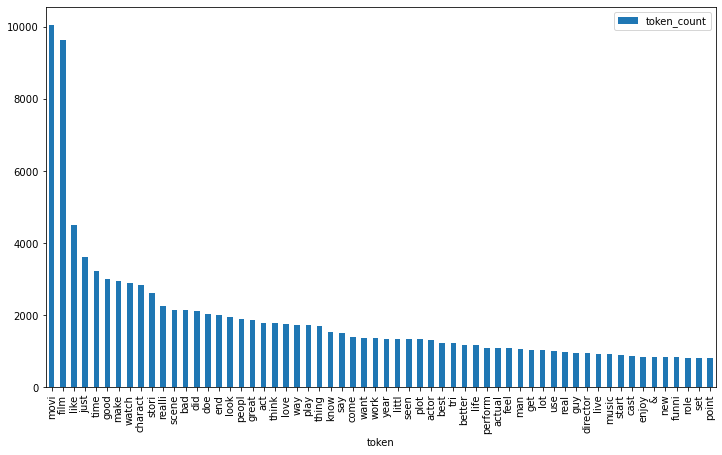

In [22]:
# bar chart of a dataframe column - print the frequency of top 60 tokens
numtoken_df[["token_count"]][:60].plot(kind="bar", figsize=(12, 7));

Frequency distribution of tokens after removing stopwords again from a differnt dictionary (SpaCy).

In [23]:
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter

# remove non-meaningful SpaCy stopwords again
def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [t for t in tokens if t not in STOP_WORDS]


counter = Counter(remove_stopwords(token_df["token"]))

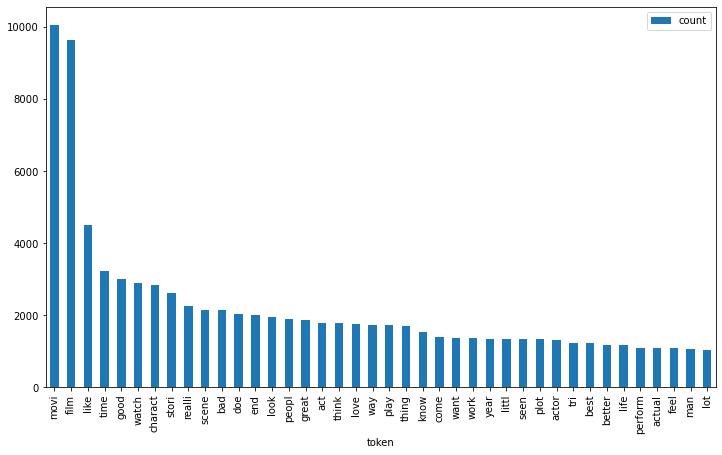

In [24]:
# convert list of tuples into data frame - plot the top 40 tokens
freq_df = pd.DataFrame.from_records(counter.most_common(40), columns=["token", "count"])

# create bar plot
freq_df.plot(kind="bar", x="token", figsize=(12, 7));

WordCloud for all reviews.

In [25]:
from wordcloud import WordCloud


def wordcloud(counter):
    """A small wordloud wrapper"""
    wc = WordCloud(width=1200, height=800, background_color="white", max_words=200)
    wc.generate_from_frequencies(counter)

    # Plot
    fig = plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

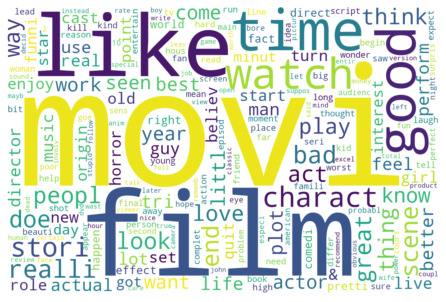

In [26]:
# create wordcloud
wordcloud(counter)

WordCloud for positive reviews.

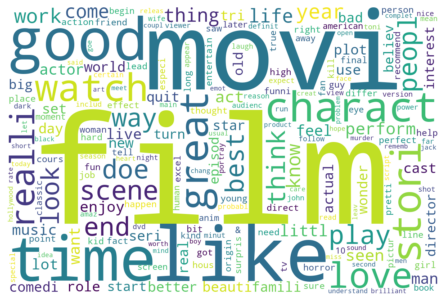

In [27]:
# wordcloud for positive reviews
counter2 = Counter(remove_stopwords(token_df[token_df["is_positive"] == 1]["token"]))
wordcloud(counter2)

WordCloud for negative reviews.

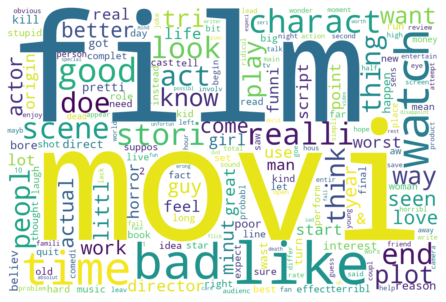

In [28]:
# wordcloud for negative reviews
counter3 = Counter(remove_stopwords(token_df[token_df["is_positive"] == 0]["token"]))
wordcloud(counter3)

# Modeling

## Bag of Words features

Attempt to use VADER to construct sentiment

In [29]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sa = SentimentIntensityAnalyzer()
# we not use lemmatized strings as vader considers tense of the word
new_train['vader_compound'] = new_train['text'].apply(lambda text: sa.polarity_scores(text.replace("\\", "").replace("b'", ""))['compound'])
# -1 to -0.05 = negative
# -0.05 to 0.05 = neutral
# 0.05 to 1 = positive
new_train

,file,text,is_positive,tokens,tokens_with_positive,vader_compound
0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1,"[(bromwel, RB), (high, JJ), (cartoon, NN), (co...","[(bromwel, RB, 1), (high, JJ, 1), (cartoon, NN...",-0.1759
1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1,"[(homeless, NN), (houseless, NN), (georg, NN),...","[(homeless, NN, 1), (houseless, NN, 1), (georg...",0.9872
2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1,"[(brilliant, JJ), (over-act, JJ), (lesley, NN)...","[(brilliant, JJ, 1), (over-act, JJ, 1), (lesle...",0.9657
3,10002_7.txt,b'This is easily the most underrated film inn ...,1,"[(easili, NN), (underr, JJ), (film, NN), (inn,...","[(easili, NN, 1), (underr, JJ, 1), (film, NN, ...",0.9806
4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1,"[(typic, NN), (mel, NN), (brook, NN), (film, N...","[(typic, NN, 1), (mel, NN, 1), (brook, NN, 1),...",0.9664
...,...,...,...,...,...,...
4995,9998_4.txt,"b""Towards the end of the movie, I felt it was ...",0,"[(end, NN), (movi, NN), (felt, VBD), (technic,...","[(end, NN, 0), (movi, NN, 0), (felt, VBD, 0), ...",0.9136
4996,9999_3.txt,b'This is the kind of movie that my enemies co...,0,"[(kind, NN), (movi, NN), (enemi, NN), (content...","[(kind, NN, 0), (movi, NN, 0), (enemi, NN, 0),...",-0.8143
4997,999_3.txt,"b""I saw 'Descent' last night at the Stockholm ...",0,"[(saw, JJ), (descent, NN), (night, NN), (stock...","[(saw, JJ, 0), (descent, NN, 0), (night, NN, 0...",-0.8705
4998,99_1.txt,"b""Some films that you pick up for a pound turn...",0,"[(film, NN), (pick, NN), (pound, NN), (turn, V...","[(film, NN, 0), (pick, NN, 0), (pound, NN, 0),...",-0.9199


Naive Bayes (NB) classifier will be used to define the model. The model assumes there is no relationship between different features where Posterior = likelihood* proposition/evidence or P(A|B) = P(B|A) * P(A)/P(B).

Benefits of using the Naive Bayes algorithm for text classification:

    - small amount of training data used to learn parameters
    - can be trained pretty fast compared to more complex models

Naive Bayes uses a zero-one loss function where the error = # of incorrect classifications. The accuracy of probability estimation is not considered by the error function, since the class with highest probability is predicted right.


Attempt to use Naive Bayes to try and construct sentiment

In [30]:
from collections import Counter

bag_of_words = []
for tokens in new_train['tokens']:
    bag_of_words.append(Counter(tokens))
    
df_bows = pd.DataFrame.from_records(bag_of_words)
df_bows = df_bows.fillna(0).astype(int)
df_bows

,"(bromwel, RB)","(high, JJ)","(cartoon, NN)","(comedi, NN)","(ran, VBD)","(time, NN)","(program, NN)","(school, NN)","(life, NN)","(teacher, RB)",...,"(inferno, JJ)","(lol, VBP)","(american-canadian, JJ)","(hardgor, JJ)","(chronicl, VBP)","(lego, NN)","(whelk, JJ)","(18,000, CD)","(ill, NNS)","(shite, JJ)"
0,1,5,1,1,1,1,1,3,1,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
4998,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,1,1,1,0,0


In [31]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb = nb.fit(df_bows, new_train['is_positive'] == 1) # convert our integer to boolean for Naive Bayes classification
predict_df = pd.DataFrame(nb.predict_proba(df_bows)).rename(columns={0: 'prob_negative', 1: 'prob_positive'})
predict_df['predict_positive'] = (predict_df['prob_positive'] > 0.5).astype(int)
new_train = pd.concat([new_train, predict_df['predict_positive']], axis=1)
new_train

,file,text,is_positive,tokens,tokens_with_positive,vader_compound,predict_positive
0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1,"[(bromwel, RB), (high, JJ), (cartoon, NN), (co...","[(bromwel, RB, 1), (high, JJ, 1), (cartoon, NN...",-0.1759,1
1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1,"[(homeless, NN), (houseless, NN), (georg, NN),...","[(homeless, NN, 1), (houseless, NN, 1), (georg...",0.9872,1
2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1,"[(brilliant, JJ), (over-act, JJ), (lesley, NN)...","[(brilliant, JJ, 1), (over-act, JJ, 1), (lesle...",0.9657,1
3,10002_7.txt,b'This is easily the most underrated film inn ...,1,"[(easili, NN), (underr, JJ), (film, NN), (inn,...","[(easili, NN, 1), (underr, JJ, 1), (film, NN, ...",0.9806,1
4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1,"[(typic, NN), (mel, NN), (brook, NN), (film, N...","[(typic, NN, 1), (mel, NN, 1), (brook, NN, 1),...",0.9664,1
...,...,...,...,...,...,...,...
4995,9998_4.txt,"b""Towards the end of the movie, I felt it was ...",0,"[(end, NN), (movi, NN), (felt, VBD), (technic,...","[(end, NN, 0), (movi, NN, 0), (felt, VBD, 0), ...",0.9136,0
4996,9999_3.txt,b'This is the kind of movie that my enemies co...,0,"[(kind, NN), (movi, NN), (enemi, NN), (content...","[(kind, NN, 0), (movi, NN, 0), (enemi, NN, 0),...",-0.8143,0
4997,999_3.txt,"b""I saw 'Descent' last night at the Stockholm ...",0,"[(saw, JJ), (descent, NN), (night, NN), (stock...","[(saw, JJ, 0), (descent, NN, 0), (night, NN, 0...",-0.8705,0
4998,99_1.txt,"b""Some films that you pick up for a pound turn...",0,"[(film, NN), (pick, NN), (pound, NN), (turn, V...","[(film, NN, 0), (pick, NN, 0), (pound, NN, 0),...",-0.9199,0


Determine our train accuracy

In [32]:
(new_train['predict_positive'] == new_train['is_positive']).sum() / len(new_train)

0.9768

We have 97.7% train accuracy. We can now use our test data to determine our test accuracy.

##### Try out Gaussian Naive Bayes Model for sentiment analysis

In [33]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(df_bows, new_train['is_positive'] == 1) # convert our integer to boolean for Gaussian Naive Bayes classification
predict_df_gnb = pd.DataFrame(GNB.predict_proba(df_bows)).rename(columns={0: 'prob_negative', 1: 'prob_positive'})
predict_df_gnb['predict_positive_gnb'] = (predict_df_gnb['prob_positive'] > 0.5).astype(int)
new_train_gnb = pd.concat([new_train, predict_df_gnb['predict_positive_gnb']], axis=1)
new_train_gnb.head()

,file,text,is_positive,tokens,tokens_with_positive,vader_compound,predict_positive,predict_positive_gnb
0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1,"[(bromwel, RB), (high, JJ), (cartoon, NN), (co...","[(bromwel, RB, 1), (high, JJ, 1), (cartoon, NN...",-0.1759,1,1
1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1,"[(homeless, NN), (houseless, NN), (georg, NN),...","[(homeless, NN, 1), (houseless, NN, 1), (georg...",0.9872,1,1
2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1,"[(brilliant, JJ), (over-act, JJ), (lesley, NN)...","[(brilliant, JJ, 1), (over-act, JJ, 1), (lesle...",0.9657,1,1
3,10002_7.txt,b'This is easily the most underrated film inn ...,1,"[(easili, NN), (underr, JJ), (film, NN), (inn,...","[(easili, NN, 1), (underr, JJ, 1), (film, NN, ...",0.9806,1,0
4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1,"[(typic, NN), (mel, NN), (brook, NN), (film, N...","[(typic, NN, 1), (mel, NN, 1), (brook, NN, 1),...",0.9664,1,1


In [34]:
new_train_gnb

,file,text,is_positive,tokens,tokens_with_positive,vader_compound,predict_positive,predict_positive_gnb
0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1,"[(bromwel, RB), (high, JJ), (cartoon, NN), (co...","[(bromwel, RB, 1), (high, JJ, 1), (cartoon, NN...",-0.1759,1,1
1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1,"[(homeless, NN), (houseless, NN), (georg, NN),...","[(homeless, NN, 1), (houseless, NN, 1), (georg...",0.9872,1,1
2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1,"[(brilliant, JJ), (over-act, JJ), (lesley, NN)...","[(brilliant, JJ, 1), (over-act, JJ, 1), (lesle...",0.9657,1,1
3,10002_7.txt,b'This is easily the most underrated film inn ...,1,"[(easili, NN), (underr, JJ), (film, NN), (inn,...","[(easili, NN, 1), (underr, JJ, 1), (film, NN, ...",0.9806,1,0
4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1,"[(typic, NN), (mel, NN), (brook, NN), (film, N...","[(typic, NN, 1), (mel, NN, 1), (brook, NN, 1),...",0.9664,1,1
...,...,...,...,...,...,...,...,...
4995,9998_4.txt,"b""Towards the end of the movie, I felt it was ...",0,"[(end, NN), (movi, NN), (felt, VBD), (technic,...","[(end, NN, 0), (movi, NN, 0), (felt, VBD, 0), ...",0.9136,0,0
4996,9999_3.txt,b'This is the kind of movie that my enemies co...,0,"[(kind, NN), (movi, NN), (enemi, NN), (content...","[(kind, NN, 0), (movi, NN, 0), (enemi, NN, 0),...",-0.8143,0,0
4997,999_3.txt,"b""I saw 'Descent' last night at the Stockholm ...",0,"[(saw, JJ), (descent, NN), (night, NN), (stock...","[(saw, JJ, 0), (descent, NN, 0), (night, NN, 0...",-0.8705,0,0
4998,99_1.txt,"b""Some films that you pick up for a pound turn...",0,"[(film, NN), (pick, NN), (pound, NN), (turn, V...","[(film, NN, 0), (pick, NN, 0), (pound, NN, 0),...",-0.9199,0,0


In [35]:
(new_train_gnb['predict_positive_gnb'] == new_train_gnb['is_positive']).sum() / len(new_train_gnb)

0.9872

#### Alternate method splitting the data into training set and test set using sklearn train_test_split:

In [36]:
#splitting the data into train and test sets:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_bows, new_train['is_positive'], test_size=0.25, random_state=5)
#here X is df_bows, and the 'is_positive column' in new_train dataframe is Y

In [37]:
#fitting the model:
GNB.fit(x_train, y_train)

GaussianNB()

In [38]:
#Evaluating the model 
from sklearn import metrics 
predicted = GNB.predict(x_test)
accuracy_score = metrics.accuracy_score(predicted, y_test)

In [39]:
print(str('{:04.2f}'.format(accuracy_score*100))+'%')

78.48%


Accuracy score using Gaussian Naive Bayes model with sklearn train_test_split method is 78.48%

## Bag of N-grams based features

Get only 3000 records to avoid out of memory issue.

In [40]:
positive_reviews = train_df[:1500]  # take first 1500 reviews which are positive
negative_reviews = train_df[23500:]  # last last 1500 reviews which are negative
new_train1 = positive_reviews.append(negative_reviews, ignore_index=True)

In [41]:
new_train1.head(5)

,file,text,is_positive
0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1
1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1
2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1
3,10002_7.txt,b'This is easily the most underrated film inn ...,1
4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1


In [42]:
from nltk.corpus import movie_reviews #  this is the corpus we will use
from nltk.stem.snowball import SnowballStemmer #  Snowball stemmer > Porter stemmer
from nltk.tokenize.casual import casual_tokenize  # we use casual tokenize because this is colloquial text
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words  # sklearn stop words is larger than nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

stemmer = SnowballStemmer("english")

def decontracted(phrase):
    # Taken from https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r'[^a-zA-Z0-9\s]', " ", phrase,re.I)
    return phrase


def tokenize_phrase(text):
    phrase = decontracted(text.replace('\\', '').replace("b'", "")) # remove backslashes and replace contractions
    tokens = casual_tokenize(phrase, reduce_len=True, strip_handles=True)
    normalized_tokens = [x.lower() for x in tokens] #  convert to all lowercase
    filtered_tokens = [x for x in normalized_tokens if x not in sklearn_stop_words] #  filter stop words
    filtered_tokens = [x for x in filtered_tokens if x and x not in '- \t\n."\':[...][\\]()/[br]<>*~,;!?'] #  filter punctuations
    lemmatized_tokens = [lemmatizer.lemmatize(t) for t in filtered_tokens] # perform lemmatization
#    stemmed_tokens = [stemmer.stem(w) for w in filtered_tokens] # perform stemming
#    pos_tokens = nltk.pos_tag(lemmatized_tokens) # perform part-of-speech tagging
    doc=' '.join(lemmatized_tokens)

    return doc

new_train1['docs'] = new_train1['text'].apply(tokenize_phrase)


In [43]:
new_train1

,file,text,is_positive,docs
0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1,bromwell high cartoon comedy ran time program ...
1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1,homelessness houselessness george carlin state...
2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1,brilliant acting lesley ann warren best dramat...
3,10002_7.txt,b'This is easily the most underrated film inn ...,1,easily underrated film inn brook cannon sure f...
4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1,typical mel brook film slapstick movie actuall...
...,...,...,...,...
2995,9998_4.txt,"b""Towards the end of the movie, I felt it was ...",0,end movie felt technical felt like classroom w...
2996,9999_3.txt,b'This is the kind of movie that my enemies co...,0,kind movie enemy content watch time bloody tru...
2997,999_3.txt,"b""I saw 'Descent' last night at the Stockholm ...",0,saw descent night stockholm film festival huge...
2998,99_1.txt,"b""Some films that you pick up for a pound turn...",0,film pick pound turn good 23rd century film re...


Select only 600 records to get Bag of 2 Grams feature to avoid out of memory issue.

In [44]:
new_train1_sub=pd.concat([new_train1.head(300), new_train1.tail(300)])

In [45]:
new_train1_sub

,file,text,is_positive,docs
0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1,bromwell high cartoon comedy ran time program ...
1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1,homelessness houselessness george carlin state...
2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1,brilliant acting lesley ann warren best dramat...
3,10002_7.txt,b'This is easily the most underrated film inn ...,1,easily underrated film inn brook cannon sure f...
4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1,typical mel brook film slapstick movie actuall...
...,...,...,...,...
2995,9998_4.txt,"b""Towards the end of the movie, I felt it was ...",0,end movie felt technical felt like classroom w...
2996,9999_3.txt,b'This is the kind of movie that my enemies co...,0,kind movie enemy content watch time bloody tru...
2997,999_3.txt,"b""I saw 'Descent' last night at the Stockholm ...",0,saw descent night stockholm film festival huge...
2998,99_1.txt,"b""Some films that you pick up for a pound turn...",0,film pick pound turn good 23rd century film re...


In [46]:
from sklearn.feature_extraction.text import CountVectorizer
bv = CountVectorizer(ngram_range=(2, 2))
bv_matrix =bv.fit_transform(new_train1_sub['docs'])

In [47]:
bv_matrix = bv_matrix.toarray()
vocab = bv.get_feature_names()
df_ngram=pd.DataFrame(bv_matrix, columns=vocab)
df_ngram

,00 abc,000 budget,000 continuity,000 plus,000 produce,007 scene,02 lifetime,05 wild,06 patrick,10 000,...,zoom cut,zoom face,zords obviously,zorro ashamed,zu warrior,zubeidaa fiza,zubeidaa nana,zyuranger series,zzzzzz oh,zzzzzz ooops
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
596,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
597,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
598,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb = nb.fit(df_ngram, new_train1_sub['is_positive'] == 1.0) # convert our integer to boolean for Naive Bayes classification
predict_df_ngram = pd.DataFrame(nb.predict_proba(df_ngram)).rename(columns={0: 'prob_negative', 1: 'prob_positive'})
predict_df_ngram['predict_positive'] = (predict_df_ngram['prob_positive'] > 0.5).astype(int)
predict_df_ngram

,prob_negative,prob_positive,predict_positive
0,5.053298e-20,1.000000e+00,1
1,1.272864e-52,1.000000e+00,1
2,2.730365e-21,1.000000e+00,1
3,1.153929e-16,1.000000e+00,1
4,4.118952e-14,1.000000e+00,1
...,...,...,...
595,1.000000e+00,1.315143e-38,0
596,1.000000e+00,1.116911e-20,0
597,1.000000e+00,4.201518e-43,0
598,1.000000e+00,3.890051e-32,0


In [49]:
new_train1_sub_ngram=new_train1_sub.reset_index()
new_train1_sub_ngram
new_train1_sub_ngram = pd.concat([new_train1_sub_ngram, predict_df_ngram['predict_positive']],axis=1)

In [50]:
new_train1_sub_ngram

,index,file,text,is_positive,docs,predict_positive
0,0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1,bromwell high cartoon comedy ran time program ...,1
1,1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1,homelessness houselessness george carlin state...,1
2,2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1,brilliant acting lesley ann warren best dramat...,1
3,3,10002_7.txt,b'This is easily the most underrated film inn ...,1,easily underrated film inn brook cannon sure f...,1
4,4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1,typical mel brook film slapstick movie actuall...,1
...,...,...,...,...,...,...
595,2995,9998_4.txt,"b""Towards the end of the movie, I felt it was ...",0,end movie felt technical felt like classroom w...,0
596,2996,9999_3.txt,b'This is the kind of movie that my enemies co...,0,kind movie enemy content watch time bloody tru...,0
597,2997,999_3.txt,"b""I saw 'Descent' last night at the Stockholm ...",0,saw descent night stockholm film festival huge...,0
598,2998,99_1.txt,"b""Some films that you pick up for a pound turn...",0,film pick pound turn good 23rd century film re...,0


In [51]:
(new_train1_sub_ngram['predict_positive'] == new_train1_sub_ngram['is_positive']).sum() / len(new_train1_sub_ngram)

1.0

Naive Bayes model based on Bag of 2 Grams features has 100% training accuracy.

## TF-IDF model based features

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)

In [53]:
tv_matrix = tv.fit_transform(new_train1['docs'])
tv_matrix = tv_matrix.toarray()
vocab = tv.get_feature_names()
df_tfidf=pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)
df_tfidf.head(5)

,00,000,0001,007,00s,01,02,029,041,05,...,zorro,zu,zubeidaa,zucker,zuckerman,zuckers,zuzz,zyada,zyuranger,zzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb_tfidf = nb.fit(df_tfidf, new_train1['is_positive'] == 1) # convert our integer to boolean for Naive Bayes classification
predict_df_tfidf = pd.DataFrame(nb_tfidf.predict_proba(df_tfidf)).rename(columns={0: 'prob_negative', 1: 'prob_positive'})
predict_df_tfidf['predict_positive'] = (predict_df_tfidf['prob_positive'] > 0.5).astype(int)

In [55]:
new_train_tfidf=new_train1
new_train_tfidf = pd.concat([new_train_tfidf, predict_df_tfidf['predict_positive']], axis=1)
new_train_tfidf.head(5)

,file,text,is_positive,docs,predict_positive
0,0_9.txt,b'Bromwell High is a cartoon comedy. It ran at...,1,bromwell high cartoon comedy ran time program ...,1
1,10000_8.txt,b'Homelessness (or Houselessness as George Car...,1,homelessness houselessness george carlin state...,1
2,10001_10.txt,b'Brilliant over-acting by Lesley Ann Warren. ...,1,brilliant acting lesley ann warren best dramat...,1
3,10002_7.txt,b'This is easily the most underrated film inn ...,1,easily underrated film inn brook cannon sure f...,1
4,10003_8.txt,b'This is not the typical Mel Brooks film. It ...,1,typical mel brook film slapstick movie actuall...,1


In [56]:
(new_train_tfidf['predict_positive'] == new_train_tfidf['is_positive']).sum() / len(new_train_tfidf)

0.9793333333333333

Naive Bayes model based on TF-IDF features has 97.9% training accuracy.

#### Trying non-Bayesian algorithms: stochastic gradient descent classifier, linear support vector classifier

In [57]:
#Splitting the Term Frequency-Inverse Document Frequency (TF-IDF) data into test and trainig sets
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tv_matrix, new_train1['is_positive'], test_size =0.25, random_state=5 )

In [58]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
SGDC = SGDClassifier()
LSVC = LinearSVC()

#on TF-IDF data
LSVC.fit(x_train_tfidf, y_train_tfidf)
accuracy_score_lsvc = metrics.accuracy_score(LSVC.predict(x_test_tfidf), y_test_tfidf)
print('accuracy_score_lsvc = '+str('{:4.2f}'.format(accuracy_score_lsvc*100))+'%')

SGDC.fit(x_train_tfidf, y_train_tfidf)
accuracy_score_sgdc = metrics.accuracy_score(SGDC.predict(x_test_tfidf), y_test_tfidf)
print('accuracy_score_sgdc = '+str('{:4.2f}'.format(accuracy_score_sgdc*100))+'%')

accuracy_score_lsvc = 90.53%
accuracy_score_sgdc = 90.80%


The accuracy score for linear support classifer with TF-IDF is 90.53%, while the accuracy score for stochastic gradient descent classifier with TF-IDF is 89.73%.

# Model Interpretation

## Feature importances of Naive Bayes model using TF-IDF features

In [70]:
X = x_train_tfidf
X_test = x_test_tfidf

#Sklearn wants the labels as one-dimensional vectors
y = np.array(y_train_tfidf).reshape((-1,))
y_test = np.array(y_test_tfidf).reshape((-1,)) 

In [59]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(df_tfidf.columns), 
                                'importance': np.array((list(nb_tfidf.coef_)[0]))})
feature_results

,feature,importance
0,00,-9.733182
1,000,-9.888836
2,0001,-10.530690
3,007,-10.453729
4,00s,-10.390928
...,...,...
25691,zuckers,-10.463031
25692,zuzz,-10.331839
25693,zyada,-10.530690
25694,zyuranger,-10.530690


In [61]:
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)
# Show the top 15 most important
feature_results.head(15)

,feature,importance
0,movie,-6.218951
1,film,-6.229466
2,great,-6.980498
3,good,-6.985103
4,story,-7.013192
5,time,-7.037825
6,like,-7.050681
7,character,-7.109363
8,just,-7.156521
9,love,-7.243408


In [62]:
from IPython.core.pylabtools import figsize
# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

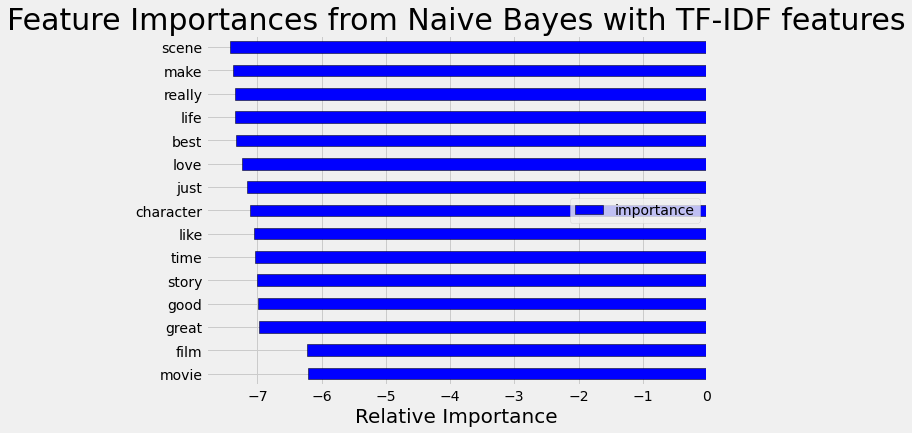

In [63]:
figsize(8, 6)
plt.style.use('fivethirtyeight')

# Plot the 15 most important features in a horizontal bar chart
feature_results.loc[:14, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Naive Bayes with TF-IDF features', size = 30);

Since all the feature importances all negative values, we can see "movie", "film", "great", "good" are the 4 most important features to the model using TF-IDF features.

#### Use Feature Importances for Feature Selection

In [71]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

train_features = df_tfidf

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (2250, 10)
Most important testing  features shape:  (750, 10)


In [75]:
#fit on a reduced set of features
nb_tfidf = nb.fit(X_reduced, y)
nb_tfidf_reduced_pred = nb.predict(X_test_reduced)

# Display results
accuracy_score_nb_tfidf_reduced = metrics.accuracy_score(nb.predict(X_test_reduced), y_test)
print('accuracy_score_nb_tfidf_reduced = '+str('{:4.2f}'.format(accuracy_score_nb_tfidf_reduced*100))+'%')

accuracy_score_nb_tfidf_reduced = 63.73%


Fitting on the reduced features lowered the accuracy score of Naive Bayes on TF-IDF features from 97.9% to 63.73%

In [77]:
# Find the residuals
residuals = abs(nb_tfidf_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

#### Locally Interpretable Model-agnostic Explanations

In [ ]:
import sys
!python -m pip install lime

In [78]:
import lime  #for explaining predictions
import lime.lime_tabular

In [79]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

In [87]:
#Try Stochastic Gradient Descent Classifier on the reduced features:
model_reduced_SGDC = SGDClassifier()

#Fit and test on the reduced set of features:
model_reduced_SGDC.fit(X_reduced, y)
model_reduced_pred = model_reduced_SGDC.predict(X_test_reduced)

accuracy_score_sgdc_reduced = metrics.accuracy_score(model_reduced_SGDC.predict(X_test_reduced), y_test)
print('accuracy_score_sgdc_reduced = '+str('{:4.2f}'.format(accuracy_score_sgdc_reduced*100))+'%')

accuracy_score_sgdc_reduced = 54.93%
